---
title:  "Introduction to Naive Bayes"
description: "Overview, assumptions, and pitfalls."
date: 2020-07-11
categories: [tutorial]
tags: [statistics]
aliases: ["/naivebayes"]
math: true
---

Naive Bayes is a simple, extraordinarily fast, and incredibly useful categorical classification tool. The underlying crux of Naive Bayes is that we assume feature independence, plug it into Bayes theorem, and the math that falls out is incredibly simple.

## The background math

Let's start with the famous Bayes Theorem:

$$ P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)} $$

On the left hand side, we have the posterior: the probability of the output given the input. On the right, we have a few terms:

* $P(X\|Y)$ - the **likelihood** - the probability of getting an input, given the output.
* $P(Y)$ - the **prior** - the probability of getting the output in general. 
* $P(X)$ - the **evidence** - which is the probability of getting some input.

<div class="aside" markdown="1">

For those coming from a model fitting side, you've probably seen this formulated using $\theta$ as the input pararameters and $x$ as the data, trying to calculate the posterior $P(\theta\|x)$. The math is the same here, our usage of things like the prior and evidence just change slightly.

</div>

What should be jumping out is that all of these terms are very easy to calculate from the data. Before we jump into an example, let me first complicate things a bit by pointing out that $X$ is not just one feature. $X$ is all our features combined. Naive Bayes is used a lot in Natural Language Processing (NLP), so lets make a dummy example to classify spam. Let us have only two features:

1. $X_1$ is whether or not the email contains our name
2. $X_2$ is whether or not the email contains the word "win"
3. $Y$ is if the email is spam.

What we are really wanting to do is predict

$$P(Y|X_1, X_2) = \frac{P(X_1, X_2 | Y) P(Y)}{P(X_1, X_2)} $$

This is where the assumption of **conditional independence** comes into play, because if we assume the features are independent, we can split up our joint probability $P(X_1, X_2)$ into $P(X_1)P(X_2)$, and the above posterior becomes:

$$P(Y|X_1, X_2) = \frac{P(X_1| Y)\ P( X_2 | Y)\ P(Y)}{P(X_1)\ P(X_2)} $$

Lets now make up 5 emails:

In [53]:
import pandas as pd

emails = [
    "Hey Sam, I hope everyone's keep up!",
    "Dear Sir/Madam. I hope this email finds you well...",
    "Hi Sam, any updates on our clients win?",
    "WHAT AN OFFER! CLICK HERE TO WIN BIG!",
    "Weekly article curation list from someone I want"
]
spam = [False, True, False, True, False]

# And turn this into a dataset
df = pd.DataFrame(dict(content=emails, spam=spam))
df["has_name"] = df.content.str.lower().str.contains("sam")
df["has_win"] = df.content.str.lower().str.contains("win")
df

,content,spam,has_name,has_win
0,"Hey Sam, I hope everyone's keep up!",False,True,False
1,Dear Sir/Madam. I hope this email finds you we...,True,False,False
2,"Hi Sam, any updates on our clients win?",False,True,True
3,WHAT AN OFFER! CLICK HERE TO WIN BIG!,True,False,True
4,Weekly article curation list from someone I want,False,False,False


Note this is *not* how you'd do tokenisation, I'm just keeping the example simple. But lets have a look at our Naive Bayes math now. To recap, we want to determine the terms in this:

$$P(Y|X_1, X_2) = \frac{P(X_1| Y)\ P( X_2 | Y)\ P(Y)}{P(X_1)\ P(X_2)} $$

Or to condense the notation down, if we have $N$ features:

$$P(Y|X) = \frac{P(Y) \prod_i^N P(X_i|Y)}{P(X)} $$

The way we'd go through and classify the emails by hand, is for each email we'd have $X_1$ is either 0 or 1, same for $X_2$ (depending on that email). To take the first email: *"Hey Sam, I hope everyone's following so far!"*, if we wanted to calculate $P(X\|Y=1)$, we'd have:

* $P(X_1=1)$ - the fraction of entries that have my name. $P(X_1=1) = 1/5$.
* $P(X_2=0)$ - the fraction of entries that **lack** the word win: $P(X_2=0) = 3/5$.
* $P(Y=1)$ - the fraction of spam in general: $2/5$.
* $P(X_1=1\|Y=1)$ -  the fraction of spam emails which have my name: $0/2$.
* $P(X_2=0\|Y=1)$ - the fraction of spam which don't have win: $1/2$.

$$P(Y=1|X) = \frac{0.4 \times 0.0 \times 0.5}{0.2 \times 0.6} = 0.0 $$


And yes, there is a slight issue here - we have a probability of zero that will turn **everything** to zero when we multiply it out, removing potentially useful information from other features! This is a pitfall to Naive Bayes, but is easily fixed. We generally implement something called Laplace Smoothing (a specific case of Lidstone smoothing), which is use here to ensure we don't get a zero probability.

The way it works is instead of just taking the fraction, we add small amount to the denominator and numerator:

$$P(X_1=1|Y=1) = \frac{0 + 1}{2 + 2} = \frac{1}{4}$$

Here I add 1 to the numerator and 2 to the denominator. The choice here is **not** locked in stone. It is also common to add a number much smaller than one to the numerator, and a larger number representative of the number of classes you have to the denominator. The choice is part of the regularisation of the model, just make sure you cant get probabilities greater than one. But once we do this smoothing, we ruin our probabilities as they aren't normalised, and so we now need to compute both spam and not spam, and compare them (instead of just checking if the probability of spam is above or below 0.5).

If we are now checking both $P(Y=1\|X)$ and $P(Y=0\|X)$, then we can also not bother computing the $P(X)$ terms, because they are the same for both calculations.

## Slow Python Implementation

Lets write some super basic code to try and classify our emails:

In [54]:
import numpy as np

def frac(x):
    # Get smoothed fraction of array thats true
    return (x.sum() + 1) / (x.size + 2)

def conditional(x_vec, x_val, y_vec, y_val):
    # Compute P(x_vec = x_val | y_vec = y_val)
     return frac(x_vec[y_vec == y_val] == x_val)

def classify_outcome(X, Y, y):
    # Get unnormalised prob for outcome y using X and Y
    probs = []
    for index, row in X.iterrows():
        # P(Y=y) term
        prob = (y == Y).astype(float).mean()
        # For everying X_i we have
        for i, x in enumerate(row):
            X_vec = X.iloc[:, i]
            # P(X_i = x | Y = y) term
            prob *= conditional(X_vec, x, Y, y)
        probs.append(prob)
    return np.array(probs)
        
def classify_emails(X, Y):
    # Inefficient row by row calculation to illustrate
    prob_spam = classify_outcome(X, Y, 1)
    prob_not_spam = classify_outcome(X, Y, 0)
    return prob_spam > prob_not_spam
    
df["prediction"] = classify_emails(df[["has_name", "has_win"]], df.spam)
df

,content,spam,has_name,has_win,prediction
0,"Hey Sam, I hope everyone's keep up!",False,True,False,False
1,Dear Sir/Madam. I hope this email finds you we...,True,False,False,True
2,"Hi Sam, any updates on our clients win?",False,True,True,False
3,WHAT AN OFFER! CLICK HERE TO WIN BIG!,True,False,True,True
4,Weekly article curation list from someone I want,False,False,False,True


So our predictions have found 3 spam emails, 2 of which are correct, and the one without my name in it from a mailing list has be flagged as well. We could play around with the amount of smoothing, and if you set it to zero you'll see that only one email gets flagged as spam. 

Lets now graduate from bad explantory code, to using `scikit-learn`.

## Scikit-Learn Code

In [59]:
from sklearn.naive_bayes import BernoulliNB

X, Y = df[["has_name", "has_win"]], df.spam

nb = BernoulliNB()
nb.fit(X, Y)
predictions = nb.predict(X)

df["BernoulliNB_pred"] = predictions
df

,content,spam,has_name,has_win,prediction,BernoulliNB_pred
0,"Hey Sam, I hope everyone's keep up!",False,True,False,False,False
1,Dear Sir/Madam. I hope this email finds you we...,True,False,False,True,True
2,"Hi Sam, any updates on our clients win?",False,True,True,False,False
3,WHAT AN OFFER! CLICK HERE TO WIN BIG!,True,False,True,True,True
4,Weekly article curation list from someone I want,False,False,False,True,True


Exactly what we got! You might have noticed the `Bernoulli` part above. There are different implementations of Naive Bayes, depending on the distribution of the data. Because all our features are 0 or 1, True or False (aka Bernoulli), we use the Bernoulli implementation. [You can see the other implementations here](https://scikit-learn.org/stable/modules/naive_bayes.html), including an example on the standard IRIS dataset. You can control how much smoothing is done using the `alpha` parameter when you create the fitter.

## When to use Naive Bayes

Now that you can see how easy it is to imlpement a Naive Bayes model, lets pause and just outline use cases, assumptions, and pitfalls so you know when you *should* and when you *shouldn't* use the technique.

* Naive Baues is **fast**. It is a great tool to get off the ground.
* It **does not** handle correlated features well, due to the assumption of independence.
* It **doesn't need much data to train**, so great for small datasets.
* It can be **misled easily** by irrelevant features.
* If you have a lot of data, [logistic regression](https://cosmiccoding.com.au/tutorials/logistic_regression) may be a [**better choice**](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf)

## How to improve our spam classifier

Obviously this write up is just providing an easy to understand example. If we wanted to take it more seriously we could:

* Include more words and determine a way to rank their importance
* Removing filler words (the, this, a, it, I, etc)
* Use lemmatization to group words (work, working, worked)
* Using n-grams to find multi-word matches.
* Include information from sender, time, location, etc
* Get a ton more data!

## Summary

Naive Bayes is a super faster, super simple classifier, that will work wonders even when you don't have much data. Its a great model for getting something off the ground, and you might be surprised at how well it performs.

If theres one thing in general to take away from this, its Bayes theorem. I'll put it big down below to drum it home!

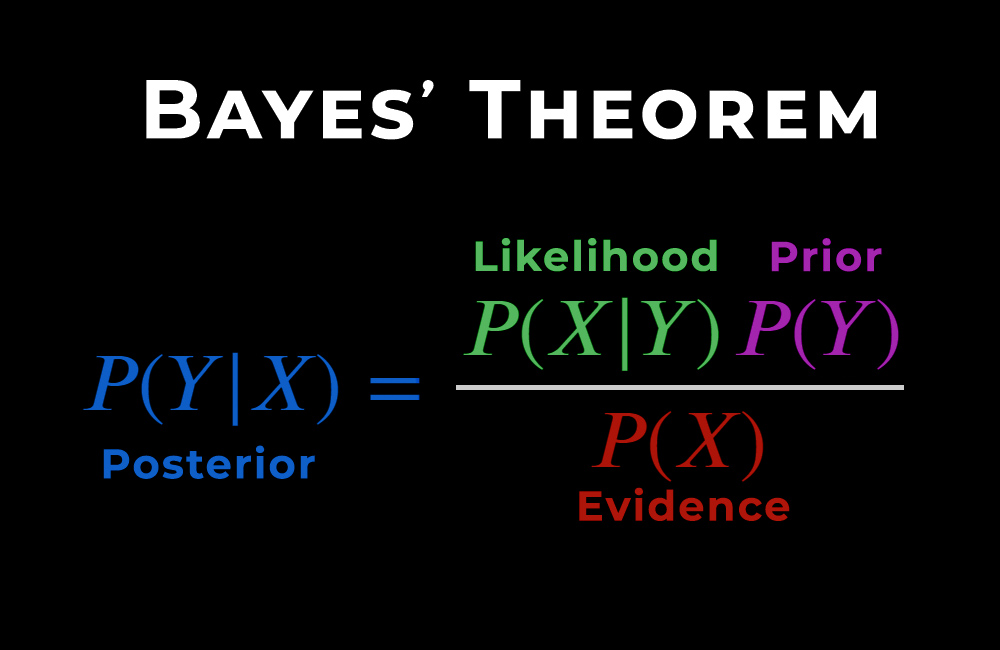

In [2]:
from IPython.display import Image
Image("naivebayes/cover.jpg")

!!! img-main small img-screen